# Прогнозирование оттока клиентов телекоммуникационной компании


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Цель проведения исследования

Наша основная цель заключается в проведении исследования данных, разработке модели прогнозирования оттока и достижении высоких показателей метрик, особенно AUC-ROC не менее 0.85, и учете метрики recall для эффективного выявления клиентов, склонных к уходу. Мы начнем с изучения выгруженных датасетов, проведем разведочный анализ данных и предобработку для подготовки к построению модели. Затем мы разработаем модель, уделяя особое внимание достижению высокой метрики AUC-ROC и обеспечению высокого значения recall. В конце проекта мы проинтерпретируем результаты модели и обеспечим бизнес ценной информацией для принятия решений по удержанию клиентов.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка и ознакомление с данными

In [4]:
# Импортируем библиотеки
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import phik
import lightgbm as lgb
import optuna


from phik.report import plot_correlation_matrix
from phik.significance import significance_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, recall_score,  classification_report
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from optuna.samplers import TPESampler

pd.set_option('display.max_columns', None)

RANDOM_STATE = 100523
numeric_columns = ['monthly_charges', 'total_charges', 'tenure']
categorical_columns = [
    'type',
    'paperless_billing',
    'payment_method',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service', 
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_t_v', 
    'streaming_movies', 
    'multiple_lines',
]

In [5]:
# Загрузим датасеты
pth1 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Final project/contract_new.csv'
pth2 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Final project/internet_new.csv'
pth3 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Final project/personal_new.csv'
pth4 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Final project/phone_new.csv'
pth5 = 'https://code.s3.yandex.net/datasets/contract_new.csv'
pth6 = 'https://code.s3.yandex.net/datasets/personal_new.csv'
pth7 = 'https://code.s3.yandex.net/datasets/internet_new.csv'
pth8 = 'https://code.s3.yandex.net/datasets/phone_new.csv'

if os.path.exists(pth1):
    contract = pd.read_csv(pth1)
    internet = pd.read_csv(pth2)
    personal = pd.read_csv(pth3)
    phone = pd.read_csv(pth4)

elif os.path.exists(pth5):
    contract = pd.read_csv(pth5)
    internet = pd.read_csv(pth6)
    personal = pd.read_csv(pth7)
    phone = pd.read_csv(pth8)
else:
    print('Something is wrong')

Something is wrong


In [7]:
# Создадим функцию для предварительного анализа данных
def analyze_df(df):
  rows, columns = df.shape
  print('Количество строк в датафрейме:', rows)
  print('Количество столбцов в датафрейме:', columns)
  df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
  display(df.head(5))
  display(df.info())
  display(df.describe())
  print('Количество полных дубликатов:', df.duplicated().sum())
  return


In [8]:
analyze_df(contract)

Количество строк в датафрейме: 7043
Количество столбцов в датафрейме: 8


,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.6
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Количество полных дубликатов: 0


In [9]:
analyze_df(internet)

Количество строк в датафрейме: 7043
Количество столбцов в датафрейме: 5


,customer_i_d,gender,senior_citizen,partner,dependents
0,7590-vhveg,female,0,yes,no
1,5575-gnvde,male,0,no,no
2,3668-qpybk,male,0,no,no
3,7795-cfocw,male,0,no,no
4,9237-hqitu,female,0,no,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_i_d    7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество полных дубликатов: 0


In [10]:
analyze_df(personal)

Количество строк в датафрейме: 5517
Количество столбцов в датафрейме: 8


,customer_i_d,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-vhveg,dsl,no,yes,no,no,no,no
1,5575-gnvde,dsl,yes,no,yes,no,no,no
2,3668-qpybk,dsl,yes,yes,no,no,no,no
3,7795-cfocw,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,fiber optic,no,no,no,no,no,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_i_d       5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_t_v      5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customer_i_d,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3671-shrsp,fiber optic,no,no,no,no,no,no
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество полных дубликатов: 0


In [11]:
analyze_df(phone)

Количество строк в датафрейме: 6361
Количество столбцов в датафрейме: 2


,customer_i_d,multiple_lines
0,5575-gnvde,no
1,3668-qpybk,no
2,9237-hqitu,no
3,9305-cdskc,yes
4,1452-kiovk,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_i_d    6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customer_i_d,multiple_lines
count,6361,6361
unique,6361,2
top,5461-qkntn,no
freq,1,3390


Количество полных дубликатов: 0


Выполним проверку на наличие полных дубликатов.

Вывод

- 1. Даты требуют приведения к формату дат

- 2. TotalCharges требует приведения к формату чисел

- 3. Большинство значений булевы, остальные можно привести к категориям

- 4. Пропусков не обнаружено

- 5. Дупликатов не обнаружено

# ПЛАН РАБОТЫ
1. Предобработка данных.

- 1.1  Привести форматы столбцов. 
- 1.2  Добавить целевой признак.
- 1.3  Добавить длительность контракта.
- 1.4  Объеденить датасеты.
- 1.5  Заполнить пропуски.

2. Графический анализ данных.

- 2.1  Построить графики для изучения данных.

3. Обучение модели.

- 3.1  Выбрать модели соответствующие задаче.
- 3.2  Выбрать метрику.
- 3.3  Подобрать гиперпараметры.
- 3.4  Обучить модели.
- 3.5  Выбрать модель с лучшими метриками.

## Разведочный анализ данных

Приведем столбцы к необходимым типам. Столбцы с датами приведем к `datetime64`, столбец итоговых затрат клиента приведем к `float64`. 

In [12]:
contract.begin_date = contract.begin_date.astype('datetime64')
contract.end_date = contract.end_date.replace(['No'], ['2020-02-01'])
contract.end_date = contract.end_date.astype('datetime64')

In [13]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors ='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


В общих затратах появились пропуски, изучим их.

In [14]:
contract[contract['total_charges'].isnull()]

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


Как видно из таблицы выше, все клиенты у которых которых появились пропуски в общих затратах, подписали контракт в день выгрузки баз, заполним пропуски текущими месячными тратами. 

In [15]:
contract.loc[contract['total_charges'].isnull(), 'total_charges'] = contract['monthly_charges']

Создадим новый признак, сколько клиент пользуется услугами компании, в днях. 

In [16]:
contract['tenure'] = (contract['end_date'] - contract['begin_date']).dt.days

Добавим целевой признак `lost`, который покажет, ушел клиент(1) или продолжает пользоваться услугами компании(0).

In [17]:
contract['lost'] = 1
contract.loc[contract['end_date'] == '2020-02-01', 'lost'] = 0

In [18]:
contract

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure,lost
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153,0
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,730,0
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,2191,0
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,337,0
7041,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,215,0


Объединим датасеты в один и выведем его на экран.

In [19]:
churn = contract.merge(internet, on='customer_i_d', how='left')
churn = churn.merge(personal, on='customer_i_d', how='left')
churn = churn.merge(phone, on='customer_i_d', how='left')
churn

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure,lost,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,730,0,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,2191,0,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,337,0,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,215,0,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


Посмотрим основную информацию о новом датасете, методом .`info()`. 

In [20]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   tenure             7043 non-null   int64         
 9   lost               7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

В объединенном датасете появились пропуски в бинарных категориальных признаках(Yes/No), заполним эти пропуски значениями No, так как отсутствие информации о пользователях услуг наиболее вероятно указывает, что клиенты не пользуются данными услугами и сервисами. И снова выведем информацию о датасете, чтобы убедиться, что пропусков не осталось. 

In [21]:
churn = churn.fillna('No')
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   tenure             7043 non-null   int64         
 9   lost               7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

Удалим признаки которые точно не пригодятся в дальнейшем анализе.

In [22]:
churn = churn.drop(['begin_date', 'end_date'], axis=1)
churn = churn.set_index('customer_i_d')

## Графический анализ данных

In [23]:
def boxplot(data, x, y, hue):
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=x, y=y, hue=hue,
                 data=data)
    plt.show()

In [24]:
def kde(data, x, hue):
  plt.figure(figsize=(8, 6))
  sns.kdeplot(data=data, x=x, hue=hue, fill=True)
  #plt.xlabel('Месячные траты клиента')
  plt.ylabel('Плотность распределения')
  #plt.title('Распределение месячных трат клиента в зависимости от оттока')
  plt.legend(['Ушедшие', 'Действующие'])
  plt.show()

Изучим месячные траты клиентов на графиках.

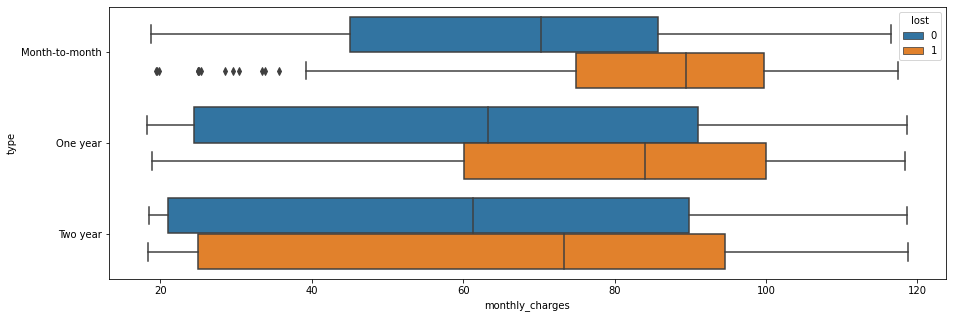

In [25]:
boxplot(churn, 'monthly_charges', 'type', 'lost')

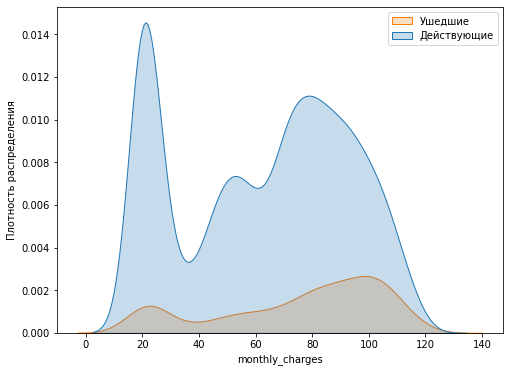

In [26]:
kde(churn, 'monthly_charges', 'lost')

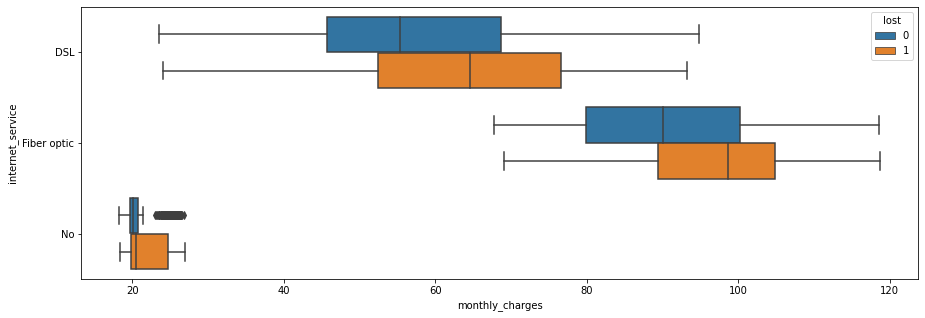

In [27]:
boxplot(churn, 'monthly_charges', 'internet_service', 'lost')

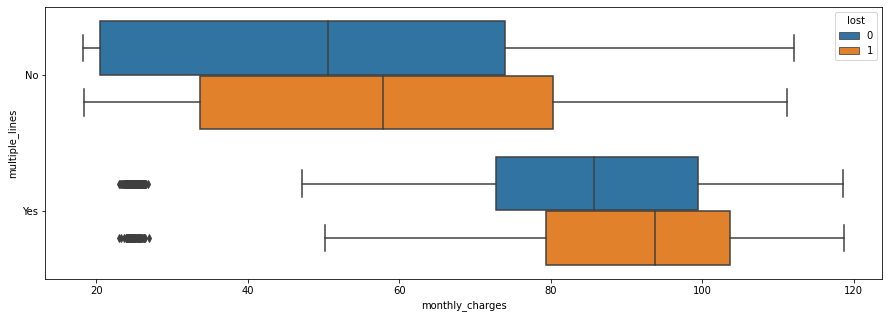

In [28]:
boxplot(churn, 'monthly_charges', 'multiple_lines', 'lost')

У ушедших клиентов заметно выше месячные расходы. Как можно заметить по графикам, больше всего платят клиенты пользующиеся дополнительными услугами. 

Изучим общие траты клиентов на графиках.

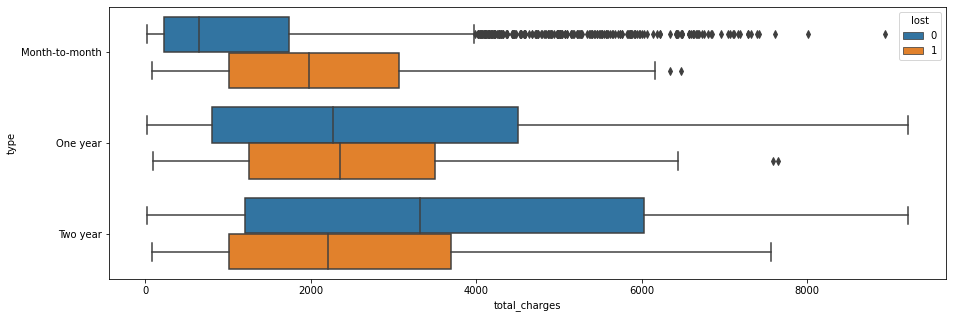

In [29]:
boxplot(churn, 'total_charges', 'type', 'lost')

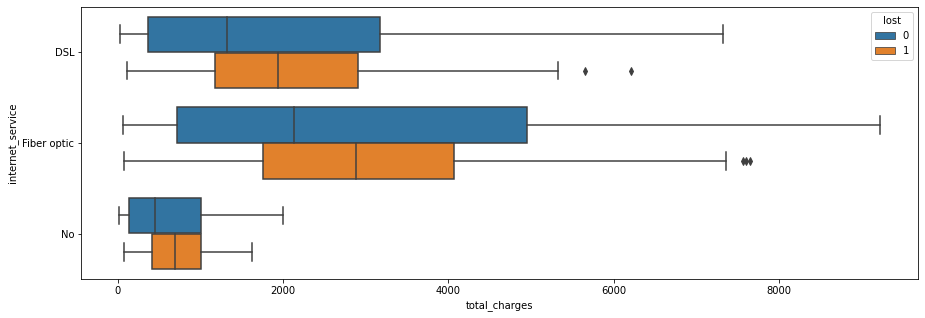

In [30]:
boxplot(churn, 'total_charges', 'internet_service', 'lost')

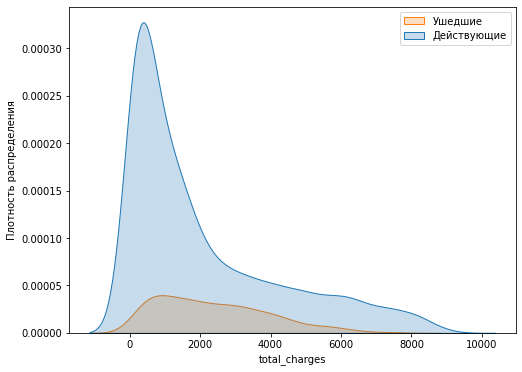

In [31]:
kde(churn, 'total_charges', 'lost')

Посмотрим как изменяется срок пользования услугами компании от типа контракта.

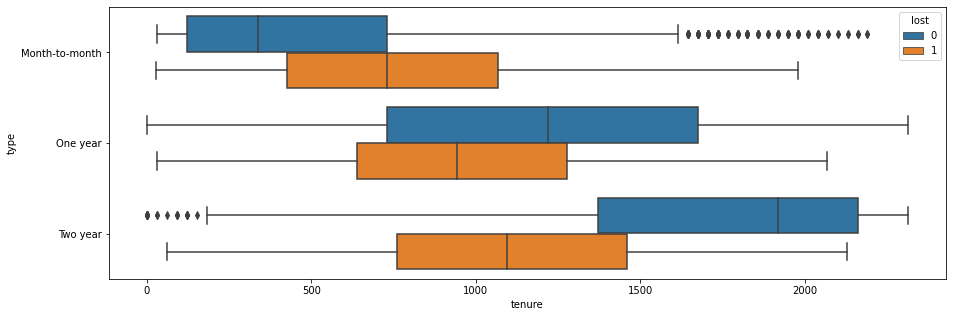

In [32]:
boxplot(churn, 'tenure', 'type', 'lost')

В среднем ушедшие клиенты на месячных тарифах пользовались услугами около 2х лет. Клиенты на годовом тарифе 2.5 - 3года. Клиенты на двухгодовом более 3 лет. 


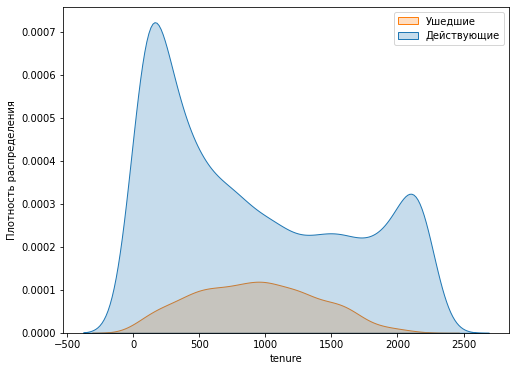

In [33]:
kde(churn, 'tenure', 'lost')

Как видим на графике больше всего клиентов уходят на третий год пользования. По двум предыдущим графикам видно, что компания теряет больше всего клиентов между вторым и четвертым годом.

Посмотрим процентное соотношение ушедших клиентов от общего числа, по типам контрактов. 

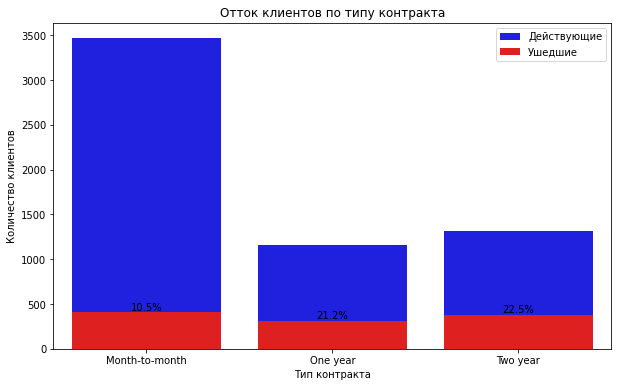

In [34]:
grouped_data = churn.groupby('type')['lost'].value_counts().unstack().fillna(0)

grouped_data['percent_lost'] = (grouped_data[1] / grouped_data.sum(axis=1)) * 100

grouped_data.sort_values(by='type', inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_data.index, y=grouped_data[0], color='b', label='Действующие')
sns.barplot(x=grouped_data.index, y=grouped_data[1], color='r', label='Ушедшие')

for i, value in enumerate(grouped_data['percent_lost']):
    plt.text(i, grouped_data[1][i], f'{value:.1f}%', ha='center', va='bottom')

plt.xlabel('Тип контракта')
plt.ylabel('Количество клиентов')
plt.title('Отток клиентов по типу контракта')
plt.legend()
plt.show()


Больше всего клиентов уходит с длительных контрактов.  

Промежуточный вывод. 

Необходимо уделить больше внимания клиентам с долгосрочными контрактами, если клиенты остаются, их лояльность достаточно высокая и средняя продолжительность пользования услугами около 5 лет. Возможно стоит предлагать клиентам с долгосрочными тарифами скидки и спецпредложения, так как на графиках трат видно, что ушедшие тратили больше чем оставшиеся, возможно их отпугнула цена услуг. 

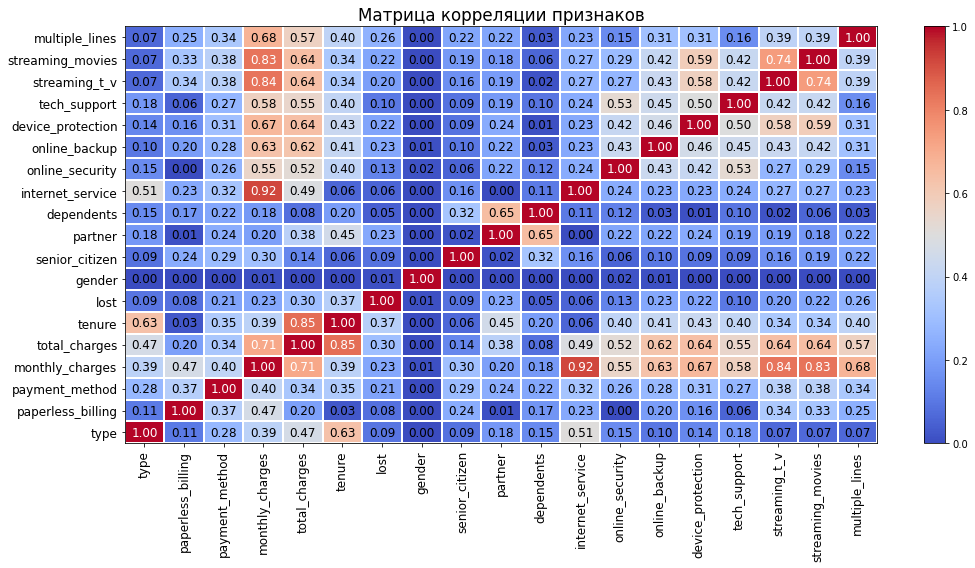

In [35]:
phik_matrix = churn.phik_matrix(interval_cols=numeric_columns)
zvalues = phik_matrix.values
xlabels = phik_matrix.columns
ylabels = phik_matrix.index

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Матрица корреляции признаков',
                        identity_layout=False, figsize=(15, 8), fontsize_factor=1.2)

In [36]:
matrix = significance_matrix(churn, interval_cols=numeric_columns)


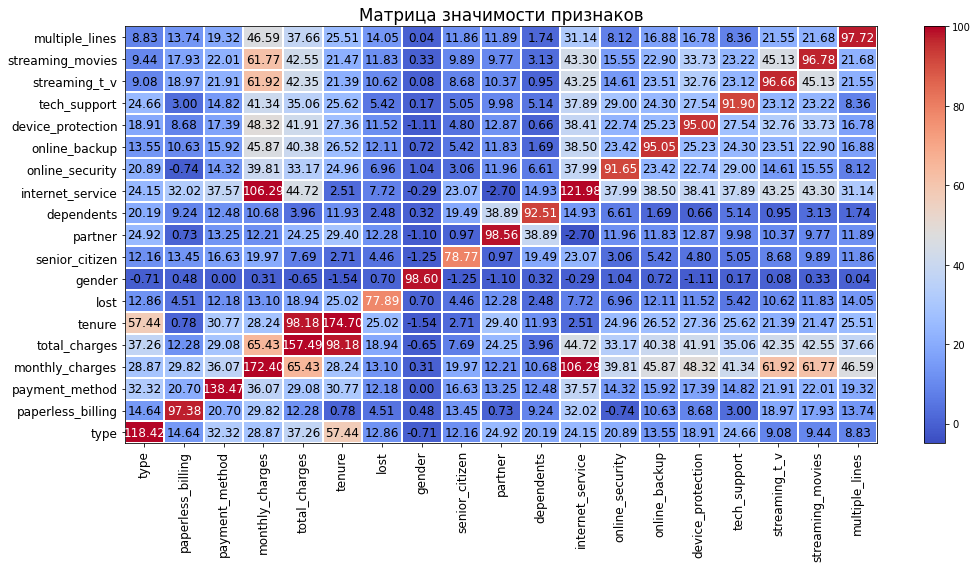

In [37]:
zvalues_1 = matrix.values
xlabels_1 = matrix.columns
ylabels_1 = matrix.index

plot_correlation_matrix(zvalues_1, x_labels=xlabels_1, y_labels=ylabels_1, 
                        vmin=-5, vmax=100, color_map='coolwarm', title='Матрица значимости признаков',
                        identity_layout=False, figsize=(15, 8), fontsize_factor=1.2)

Признак гендер практически не имеет корреляции с остальными признаками, удалим его. Между признаками дополнительных интернет сервисов существует корреляция, стоит объядинить их в один и удалить уже существующие, т.к. они будут конкурировать между собой и могут ухудшить качество модели. 

In [38]:
churn['int_services'] = churn[['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies']].apply(lambda row: row.tolist().count('Yes'), axis=1)

In [39]:
churn = churn.drop(['gender', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies'], axis=1)


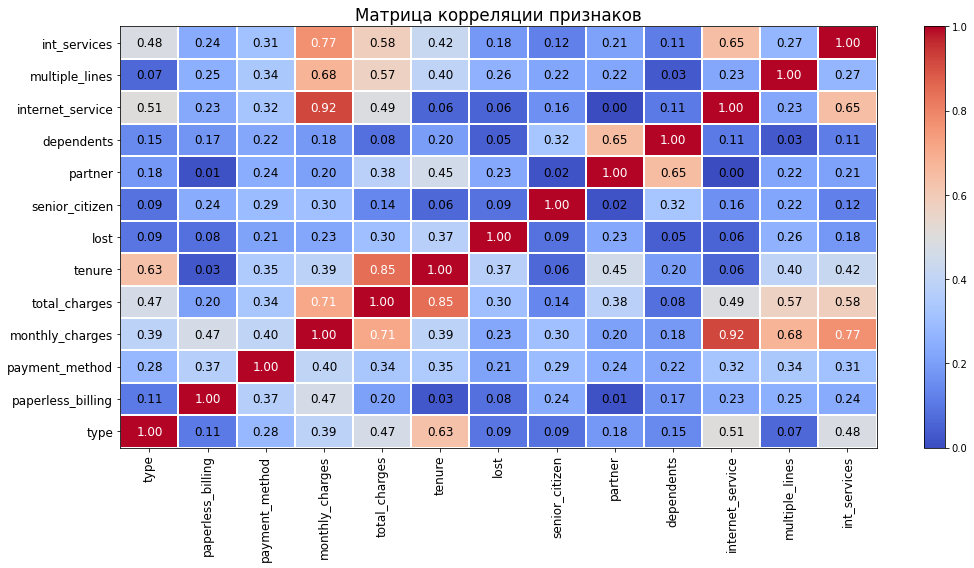

In [40]:
phik_matrix = churn.phik_matrix(interval_cols=numeric_columns)
zvalues = phik_matrix.values
xlabels = phik_matrix.columns
ylabels = phik_matrix.index

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Матрица корреляции признаков',
                        identity_layout=False, figsize=(15, 8), fontsize_factor=1.2)

Изучим баланс классов в датасете.

In [41]:
class_imbalance = churn['lost'].value_counts()
print(class_imbalance)
print('Дисбаланс классов:', class_imbalance[0] / class_imbalance[1])

0    5942
1    1101
Name: lost, dtype: int64
Дисбаланс классов: 5.396911898274296


В данных есть дисбаланс, класс 0 превосходит класс 1 более чем в 5 раз. Для борьбы с дисбалансом будем использовать внутренние средства балансировки в моделях, если говорить точнее параметр `class_weight` установим как `'balanced'`.

## Обучение моделей

Создадим признаки для обучения.

In [42]:
features = churn.drop(['lost'], axis=1)
target = churn['lost']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE
)

print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (5282, 12)
Размер тестовой выборки: (1761, 12)


In [43]:
features

,type,paperless_billing,payment_method,monthly_charges,total_charges,tenure,senior_citizen,partner,dependents,internet_service,multiple_lines,int_services
customer_i_d,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,31,0,Yes,No,DSL,No,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1036,0,No,No,DSL,No,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,123,0,No,No,DSL,No,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0,No,No,DSL,No,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,153,0,No,No,Fiber optic,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,84.80,2035.20,730,0,Yes,Yes,DSL,Yes,5
2234-XADUH,One year,Yes,Credit card (automatic),103.20,7430.40,2191,0,Yes,Yes,Fiber optic,Yes,4
4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,325.60,337,0,Yes,Yes,DSL,No,1


Разделим столбцы по способу кодирования/масштабирования(OHE, Ordinal, Numeric).

In [44]:
numeric_columns = ['monthly_charges', 'total_charges', 'tenure']
ordinal_columns = ['type', 'payment_method', 'internet_service', 'multiple_lines', 'int_services']
ohe_columns = [ 
    'payment_method', 
    'paperless_billing',
    'senior_citizen',
    'partner',
    'dependents'  
    
]

Создадим транфсормер для столбцов и трансформируем признаки.

In [45]:
# Масштабируем числовые признаки и трансформируем категориальные признаки
col_trans = make_column_transformer(
    (OneHotEncoder(drop='first'), ohe_columns),
    (OrdinalEncoder(), ordinal_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough'
)
features_train_enc = col_trans.fit_transform(features_train)
features_test_enc = col_trans.transform(features_test)

# Получение имен столбцов после кодирования
encoded_columns = col_trans.named_transformers_['onehotencoder'].get_feature_names_out(ohe_columns).tolist()
ordinal_columns = col_trans.named_transformers_['ordinalencoder'].get_feature_names_out(ordinal_columns).tolist()
numeric_columns = col_trans.transformers_[-1][2]

# Объединение имен столбцов
column_names = encoded_columns + ordinal_columns + numeric_columns

# Создание DataFrame с назначением имен столбцам
features_train_enc = pd.DataFrame(features_train_enc, columns=column_names)
features_test_enc = pd.DataFrame(features_test_enc, columns=column_names)

print(features_train_enc.shape)
print(features_test_enc.shape)

(5282, 15)
(1761, 15)


In [46]:
features_train_enc

,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,paperless_billing_Yes,senior_citizen_1,partner_Yes,dependents_Yes,type,payment_method,internet_service,multiple_lines,int_services,monthly_charges,total_charges,tenure
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,0.0,-1.302999,-0.307103,1.242360
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.013867,-0.224012,-0.543306
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,4.0,0.533886,1.971171,1.826813
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,0.469113,0.959823,0.976566
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,-0.467599,-0.948487,-1.212931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,-1.475726,-0.399537,1.246765
5278,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.191577,0.443650,0.038210
5279,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,4.0,1.331087,2.304679,1.647659
5280,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,-1.477387,-0.785798,-0.318630


Создадим функцию оптимизации гиперпараметров. На вход на будет принимать модель, а так же гиперпараметры которые необходимо оптимизировать. Для оптимизации будем использовать библиотеку Optuna.

In [47]:
def optimize_model(model, features, target, int_params, float_params, n_trials=100):
    def objective(trial):
        model_params = {}
        for param_name, param_values in int_params.items():
            model_params[param_name] = trial.suggest_int(param_name, param_values[0], param_values[1])

        for param_name, param_values in float_params.items():
            model_params[param_name] = trial.suggest_float(param_name, param_values[0], param_values[1])

        
        model.set_params(**model_params)
        score = cross_val_score(model, features, target, scoring='roc_auc', cv=5, n_jobs=-1).mean()
        return score

    sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
    study = optuna.create_study(direction='maximize', study_name='opt', sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_trial.params
    best_score = study.best_trial.value

    print(best_params)
    print(best_score)

    return best_params, best_score


### Модель стохастического градиентного спуска

In [48]:
%%time
int_params_sgd = {
    'max_iter': [100, 1000]
}

float_params_sgd = {
    'alpha': [0.0001, 1.0]
}

best_params, best_score = optimize_model(SGDClassifier(class_weight='balanced', random_state=RANDOM_STATE), features_train_enc, target_train, int_params_sgd, float_params_sgd, n_trials=100)


[I 2023-05-16 12:40:03,015] A new study created in memory with name: opt
[I 2023-05-16 12:40:03,168] Trial 0 finished with value: 0.6827346278392972 and parameters: {'max_iter': 453, 'alpha': 0.8178067449330351}. Best is trial 0 with value: 0.6827346278392972.
[I 2023-05-16 12:40:03,228] Trial 1 finished with value: 0.6924892564842609 and parameters: {'max_iter': 945, 'alpha': 0.4932214340542712}. Best is trial 1 with value: 0.6924892564842609.
[I 2023-05-16 12:40:03,287] Trial 2 finished with value: 0.6898034376262604 and parameters: {'max_iter': 988, 'alpha': 0.5539233300225114}. Best is trial 1 with value: 0.6924892564842609.
[I 2023-05-16 12:40:03,361] Trial 3 finished with value: 0.6816936044520824 and parameters: {'max_iter': 823, 'alpha': 0.8693594154619629}. Best is trial 1 with value: 0.6924892564842609.
[I 2023-05-16 12:40:03,423] Trial 4 finished with value: 0.7457874548436171 and parameters: {'max_iter': 110, 'alpha': 0.03864826506180887}. Best is trial 4 with value: 0.7457

{'max_iter': 122, 'alpha': 0.0019409237998169997}
0.7499217154642279
CPU times: user 3.36 s, sys: 156 ms, total: 3.51 s
Wall time: 8.82 s


Модель показала себя крайне слабо на данной задаче и не достигла минимальной метрики качества AUC-ROC 0.85.

### Модель случайного леса

In [49]:
%%time
params_int_rf = {
        'n_estimators': [400, 600],
        'max_depth': [3, 10],
        #'min_samples_split': [2, 10],
        #'min_samples_leaf': [1, 10]
    }

params_float_rf = {
    'max_features': [0.1, 1.0]
}

best_params_rf, best_score_rf = optimize_model(RandomForestClassifier(random_state=RANDOM_STATE), features_train_enc, target_train, params_int_rf, params_float_rf, n_trials=50)

[I 2023-05-16 12:40:11,839] A new study created in memory with name: opt
[I 2023-05-16 12:40:29,240] Trial 0 finished with value: 0.8374256454502647 and parameters: {'n_estimators': 478, 'max_depth': 9, 'max_features': 0.9447983364845353}. Best is trial 0 with value: 0.8374256454502647.
[I 2023-05-16 12:40:44,126] Trial 1 finished with value: 0.836310323781906 and parameters: {'n_estimators': 499, 'max_depth': 10, 'max_features': 0.5984908461048707}. Best is trial 0 with value: 0.8374256454502647.
[I 2023-05-16 12:40:49,814] Trial 2 finished with value: 0.8160216942693117 and parameters: {'n_estimators': 561, 'max_depth': 9, 'max_features': 0.11074314556578486}. Best is trial 0 with value: 0.8374256454502647.
[I 2023-05-16 12:40:59,031] Trial 3 finished with value: 0.8335891616334873 and parameters: {'n_estimators': 407, 'max_depth': 6, 'max_features': 0.6472256479861094}. Best is trial 0 with value: 0.8374256454502647.
[I 2023-05-16 12:41:13,733] Trial 4 finished with value: 0.8377923

{'n_estimators': 542, 'max_depth': 8, 'max_features': 0.9846147588996785}
0.8385334135299262
CPU times: user 4.76 s, sys: 488 ms, total: 5.24 s
Wall time: 12min 46s


Данная модель показала более высокий результат, однако так же не достигла минимального значения AUC-ROC в 0.85.

### Модель LightGBM

In [50]:
%%time
params_int_lgbm = {'num_leaves': [10, 1000],
              'max_depth': [1, 16],
              'min_child_samples': [1, 20],
              'reg_alpha': [0, 10],
              'reg_lambda': [0, 10]
}

params_float_lgbm = {'learning_rate': [0.001, 1],
                }

best_params_lgbm, best_score_lgbm = optimize_model(LGBMClassifier(class_weight='balanced', objective='binary', metric='auc', random_state=RANDOM_STATE), features_train_enc, target_train, params_int_lgbm, params_float_lgbm, n_trials=100)

[I 2023-05-16 12:52:58,404] A new study created in memory with name: opt
[I 2023-05-16 12:52:59,619] Trial 0 finished with value: 0.8470002371301494 and parameters: {'num_leaves': 398, 'max_depth': 14, 'min_child_samples': 19, 'reg_alpha': 5, 'reg_lambda': 10, 'learning_rate': 0.5543248391764065}. Best is trial 0 with value: 0.8470002371301494.
[I 2023-05-16 12:53:01,241] Trial 1 finished with value: 0.8559001877561945 and parameters: {'num_leaves': 805, 'max_depth': 14, 'min_child_samples': 1, 'reg_alpha': 0, 'reg_lambda': 4, 'learning_rate': 0.6084204692645815}. Best is trial 1 with value: 0.8559001877561945.
[I 2023-05-16 12:53:01,793] Trial 2 finished with value: 0.8484368089532272 and parameters: {'num_leaves': 262, 'max_depth': 14, 'min_child_samples': 16, 'reg_alpha': 1, 'reg_lambda': 2, 'learning_rate': 0.823880931842133}. Best is trial 1 with value: 0.8559001877561945.
[I 2023-05-16 12:53:02,495] Trial 3 finished with value: 0.8598932557854481 and parameters: {'num_leaves': 21

{'num_leaves': 59, 'max_depth': 2, 'min_child_samples': 6, 'reg_alpha': 1, 'reg_lambda': 0, 'learning_rate': 0.8828688816893316}
0.8901151965296572
CPU times: user 5.46 s, sys: 249 ms, total: 5.71 s
Wall time: 38.2 s


Модель себя отлично показала и показала метрику AUC-ROC в 0.89 на кросс валидации обучающей выборки.

### Модель CatBoost

In [ ]:
%%time
params_int_cat = {'iterations': [100, 1000],
              'max_depth': [1, 16],
              'l2_leaf_reg': [5, 50],
              'random_strength': [5, 50]
}

params_float_cat = {'learning_rate': [0.001, 1],
                }

best_params_cat, best_score_cat = optimize_model(CatBoostClassifier(class_weights=[1, 5], loss_function='Logloss', eval_metric='AUC', verbose=100, random_state=RANDOM_STATE), features_train_enc, target_train, params_int_cat, params_float_cat, n_trials=100)

In [51]:
best_score_cat = 0.925365226966842

- Best trial: {'iterations': 729, 'learning_rate': 0.6257786720285585, 'max_depth': 2, 'l2_leaf_reg': 28, 'random_strength': 13}
- Best AUC-ROC: 0.9222231738651658
- CPU times: user 1min, sys: 6.17 s, total: 1min 6s
- Wall time: 2h 45min 18s

Данная модель показала себя лучше всех остальных, достигнув значения метрики AUC-ROC в 0.92. Эта модель будет использована далее для тестирования. 

In [53]:
results = pd.DataFrame({
    'Model': ['SGDClassifier', 'RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier'],
    'Best AUC-ROC': [best_score, best_score_rf, best_score_lgbm, best_score_cat],
})

display(results)

,Model,Best AUC-ROC
0,SGDClassifier,0.749922
1,RandomForestClassifier,0.838533
2,LGBMClassifier,0.890115
3,CatBoostClassifier,0.925365


## Тестирование лучшей модели и интерпретация результатов ее работы

In [54]:
%%time
best_params_cat = {'iterations': 729, 'learning_rate': 0.6257786720285585, 'max_depth': 2, 'l2_leaf_reg': 28, 'random_strength': 13}
class_weights = [1, 5]
cbclassifier = CatBoostClassifier(**best_params_cat, class_weights=class_weights, verbose=100)
cbclassifier.fit(features_train_enc, target_train)
pred = cbclassifier.predict(features_test_enc)
probabilities_one_test = cbclassifier.predict_proba(features_test_enc)[:, 1]
auc_cb = roc_auc_score(target_test, probabilities_one_test)
accuracy = accuracy_score(target_test, pred)
print('\nAUC-ROC на тестовой выборке:', auc_cb, '\nAccuracy на тестовой выборке:', accuracy, '\n')

0:	learn: 0.6675430	total: 48.5ms	remaining: 35.3s
100:	learn: 0.3575706	total: 180ms	remaining: 1.12s
200:	learn: 0.2872448	total: 311ms	remaining: 816ms
300:	learn: 0.2482151	total: 440ms	remaining: 625ms
400:	learn: 0.2233392	total: 572ms	remaining: 468ms
500:	learn: 0.2024780	total: 710ms	remaining: 323ms
600:	learn: 0.1867266	total: 843ms	remaining: 180ms
700:	learn: 0.1741355	total: 972ms	remaining: 38.8ms
728:	learn: 0.1710112	total: 1.01s	remaining: 0us

AUC-ROC на тестовой выборке: 0.916582650189649 
Accuracy на тестовой выборке: 0.8915388983532084 

CPU times: user 1.65 s, sys: 205 ms, total: 1.85 s
Wall time: 1.11 s


In [55]:
def plot_roc_curve(target_test_enc, probabilities_one_test):
    print('ROC-AUC score', auc_cb)
    
    fpr, tpr, thresholds = roc_curve(target_test_enc, probabilities_one_test)

    plt.figure(figsize=(10, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

ROC-AUC score 0.916582650189649


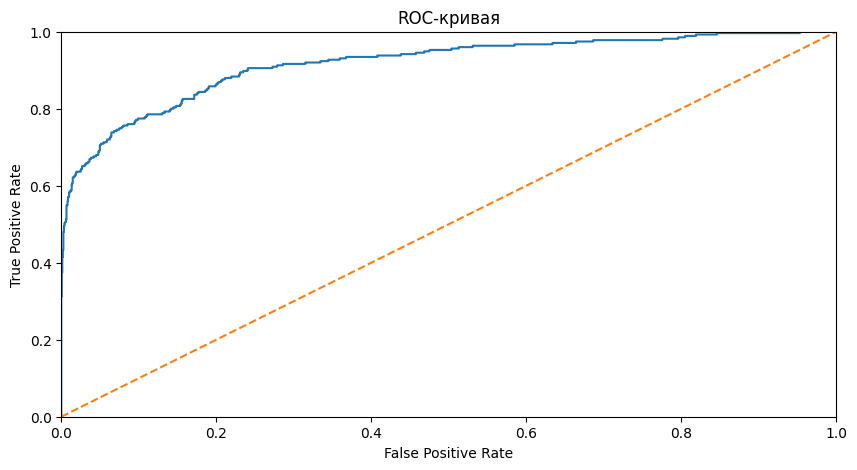

In [56]:
plot_roc_curve(target_test, probabilities_one_test)

Нам удалось получить высокую метрику AUC-ROC, однако с точки зрения бизнеса она плохо интерпретируема, рассмотрим матрицу ошибок чтобы понять распределение ошибок первого и второго рода, а так же выведем отчет по классификации.  

In [57]:
cm = confusion_matrix(target_test, pred)
cm

array([[1362,  124],
       [  67,  208]])

In [58]:
report = classification_report(target_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1486
           1       0.63      0.76      0.69       275

    accuracy                           0.89      1761
   macro avg       0.79      0.84      0.81      1761
weighted avg       0.90      0.89      0.90      1761



Хоть у нас и высокий AUC, модель не идеально прогнозирует положительный класс, который для нас наиболее важен. С учетом ТЗ заказчика, нас больше всего интересуют ошибки второго рода, так как для нас более важна полнота, чем точность модели. Заказчику важно определить всех клиентов, которые планируют рассторгнуть договор и предложить им дополнительные преференции, чтобы убедить их остаться. Для этого мы можем менять порог, посмотрим что получится.  

In [59]:
pred_adjusted = (probabilities_one_test > 0.2)
recall = recall_score(target_test, pred_adjusted)
report_adjusted = classification_report(target_test, pred_adjusted)
print(report_adjusted)

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1486
           1       0.39      0.91      0.54       275

    accuracy                           0.76      1761
   macro avg       0.68      0.82      0.69      1761
weighted avg       0.88      0.76      0.79      1761



In [60]:
cm = confusion_matrix(target_test, pred_adjusted)
cm

array([[1094,  392],
       [  26,  249]])

Значение полноты стало равным 90%, количество ложно-отрицательных ответов снизилось. Необходимо уточнить у заказчика, какое значение метрики recall он хотел бы видеть на выходе. 

Проверим какие признаки являются лучшими для нашей лучшей модели.

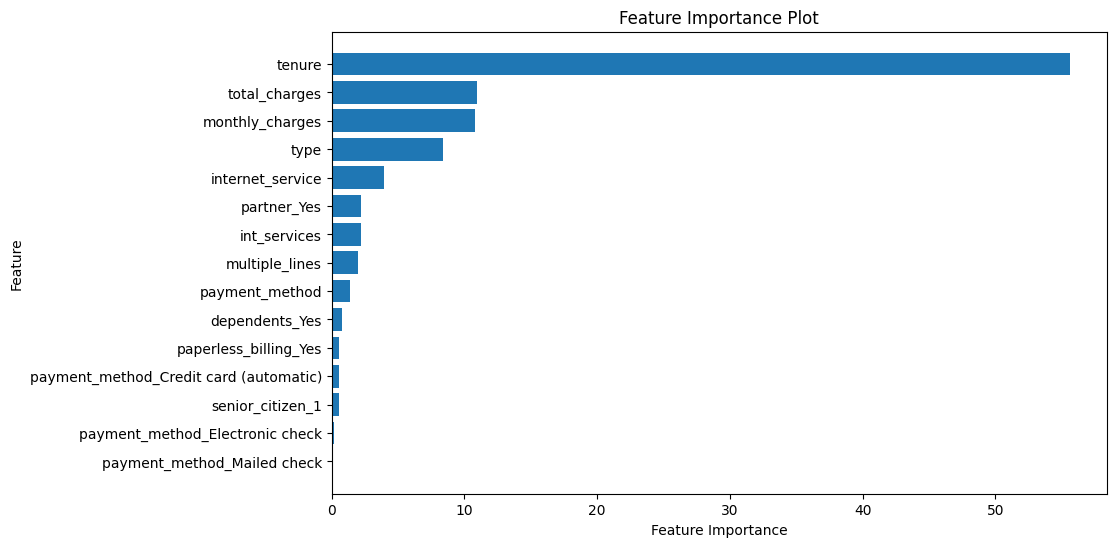

In [61]:
# Получение важности признаков
feature_importance = cbclassifier.feature_importances_

# Получение названий признаков
feature_names = features_train_enc.columns

# Сортировка признаков по их важности
sorted_idx = np.argsort(feature_importance)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(feature_importance)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

Наиболее важными параметрами для модели являются:
- количество времени, которое действует договор с клиентом
- месячные траты клиента
- общие траты
- тип договора

## Отчёт по финальному проекту.

# Отчет по проекту: Прогнозирование оттока клиентов телекоммуникационной компании «Ниединогоразрыва.ком»

**1. Введение.**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта:** Прогнозирование оттока клиентов с высокой точностью и полнотой, а так же интерпретацией результатов.

**Описание цели:** Наша основная цель заключается в проведении исследования данных, разработке модели прогнозирования оттока и достижении высоких показателей метрик, особенно AUC-ROC не менее 0.85, и учете метрики recall для эффективного выявления клиентов, склонных к уходу. Мы начнем с изучения выгруженных датасетов, проведем разведочный анализ данных и предобработку для подготовки к построению модели. Затем мы разработаем модель, уделяя особое внимание достижению высокой метрики AUC-ROC и обеспечению высокого значения recall. В конце проекта мы проинтерпретируем результаты модели и обеспечим бизнес ценной информацией для принятия решений по удержанию клиентов.

**Оператор предоставляет два основных типа услуг:**

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**2. Обзор данных.**

Создали функцию "analyze_df", она проводит предварительный анализ данных и включает следующие этапы:

- Определение размерности датафрейма.
- Преобразование названий столбцов в "змеиный" регистр.
- Приведение данных к нижнему регистру.
- Вывод первых 5 строк данных: Функция выводит первые 5 строк датафрейма, чтобы получить представление о его содержимом и структуре.
- Информация о датафрейме: Функция выводит информацию о датафрейме, включая типы данных столбцов и общее количество непустых значений. Это позволяет оценить наличие пропущенных данных и подготовиться к их обработке.
- Описательная статистика: Функция выводит описательную статистику для числовых столбцов датафрейма, такую как среднее значение, стандартное отклонение, минимальное и максимальное значения. Это помогает понять распределение данных и выявить потенциальные выбросы или аномалии.
- Поиск дубликатов.

На основе проведенного предварительно анализа сформировали План работы:

1. Предобработка данных.

- 1.1  Привести форматы столбцов. 
- 1.2  Добавить целевой признак.
- 1.3  Добавить длительность контракта.
- 1.4  Объеденить датасеты.
- 1.5  Заполнить пропуски.

2. Графический анализ данных.

- 2.1  Построить графики для изучения данных.

3. Обучение модели.

- 3.1  Выбрать модели соответствующие задаче.
- 3.2  Выбрать метрику.
- 3.3  Подобрать гиперпараметры.
- 3.4  Обучить модели.
- 3.5  Выбрать модель с лучшими метриками.

**3. Предобработка данных.**

На данном этапе были выполнены следующие шаги:

1. Изменение типа данных столбцов "begin_date" и "end_date": Столбцы были преобразованы в тип данных 'datetime64', чтобы корректно обрабатывать даты.
2. Заполнение пропущенных значений в столбце "end_date": Значение 'No' было заменено на '2020-02-01', предполагая, что пропуски означают текущую дату выгрузки базы данных.
3. Преобразование столбца "total_charges" в числовой формат: Столбец был преобразован в числовой тип данных с помощью функции pd.to_numeric(), при этом значения, которые не могли быть преобразованы, были заменены на NaN.
4. Обработка пропущенных значений в столбце "total_charges": Все строки, где значение "total_charges" было пропущено, были заполнены значениями из столбца "monthly_charges". Предполагается, что клиенты, у которых отсутствует информация о общих затратах, имели те же месячные траты.
5. Создание нового признака "tenure": Был добавлен новый признак, показывающий количество дней, в течение которых клиент пользуется услугами компании. Этот признак вычисляется как разница между датами "end_date" и "begin_date".
6. Добавление целевого признака "lost": Был создан целевой признак "lost", который указывает, ушел ли клиент (значение 1) или продолжает пользоваться услугами компании (значение 0). Клиенты, у которых "end_date" равно '2020-02-01', считаются продолжающими пользоваться услугами компании.
7. Объединение датасетов: Были объединены датасеты "contract", "internet", "personal" и "phone" по полю "customer_i_d" с использованием метода merge(). Результирующий датасет был сохранен в переменной "churn".
8. Обработка пропущенных значений в объединенном датасете: Пропущенные значения в бинарных категориальных признаках были заполнены значением 'No', предполагая, что отсутствие информации о пользовании определенной услугой указывает на ее отсутствие у клиента.
9. Удаление лишних признаков: Были удалены признаки "begin_date" и "end_date", так как они не предоставляют полезной информации для анализа. Также столбец "customer_i_d" был установлен в качестве индекса датасета "churn".

Эти шаги помогли подготовить данные для дальнейшего анализа и построения модели прогнозирования оттока клиентов.

**4. Графический анализ данных.**

На данном этапе был проведен графический анализ данных для выявления закономерностей и понимания влияния различных признаков на отток клиентов. Были построены следующие графики:

1. Boxplot для месячных трат клиентов в зависимости от типа услуги и оттока. График показал, что ушедшие клиенты обычно имеют более высокие месячные траты, особенно если они пользовались дополнительными услугами.
2. График плотности распределения (KDE) для месячных трат клиентов в зависимости от оттока. График подтвердил, что ушедшие клиенты имеют более высокие месячные траты по сравнению с оставшимися.
3. Boxplot и графики плотности распределения для общих трат клиентов. Общие траты ушедших клиентов также были выше, особенно для клиентов с дополнительными услугами.
4. Boxplot для срока пользования услугами в зависимости от типа контракта и оттока. График показал, что клиенты, ушедшие на месячном тарифе, обычно пользовались услугами около 2 лет, в то время как клиенты на двухгодовом контракте имели более долгий срок пользования.
5. График плотности распределения для срока пользования услугами в зависимости от оттока. График показал, что наибольший отток происходит в районе третьего года пользования.
6. График процентного соотношения ушедших клиентов по типам контрактов. График показал, что больше всего клиентов уходит с долгосрочных контрактов.

В результате анализа можно сделать следующие выводы:

- Ушедшие клиенты имели более высокие месячные и общие траты по сравнению с оставшимися клиентами.
- Клиенты, пользующиеся дополнительными услугами, обычно имели более высокие траты и более склонны к оттоку.
- Срок пользования услугами имеет влияние на отток, причем третий год пользования является критическим периодом.
- Клиенты с долгосрочными контрактами более лояльны, однако существует потенциал для улучшения их удержания путем предоставления скидок и специальных предложений.


Так же, на данном этапе был проведен анализ корреляции признаков и проверка на мультиколлинеарность с использованием матрицы фиксированной величины (phik_matrix) и матрицы значимости признаков. Были выполнены следующие действия:

1. Создана матрица корреляции признаков с использованием метода phik_matrix из библиотеки phik.
2. Построена графическая визуализация матрицы корреляции признаков с помощью функции plot_correlation_matrix. График позволяет наглядно оценить взаимосвязи между признаками.
![cof_matrix](corr_mat.png)
![cof_matrix](sign_mat.png)
Выявлены следующие важные наблюдения:

- Признак "gender" имеет незначительную корреляцию с остальными признаками и был удален.
- Между признаками дополнительных интернет-услуг (online_security, online_backup, device_protection, tech_support, streaming_t_v, streaming_movies) обнаружена корреляция. Был создан новый синтетический признак "int_services", объединяющий информацию о наличии дополнительных интернет-услуг.
- Удалены признаки, которые были использованы для создания нового признака "int_services".
- Повторно была построена матрица корреляции признаков для обновленного датасета.
![cof_matrix](corr_mat2.png)

Для баланса классов был проанализирован дисбаланс классов в целевой переменной "lost". Было выявлено, что классы несбалансированы, с соотношением примерно 1:5 между классами "Активный клиен" и "Ушедший". Это может потенциально повлиять на обучение модели и требует учета при выборе соответствующих методов борьбы с дисбалансом классов.

**5. Обучение моделей.**

На данном этапе были созданы признаки для обучения моделей. Исходные данные были разделены на обучающую и тестовую выборки в соотношении 75:25 с помощью стратифицированного разбиения.

Затем были определены три типа признаков: числовые, упорядоченные и категориальные для кодирования.

Для числовых признаков было выполнено их масштабирование с помощью стандартизации.

Для категориальных признаков были применены два метода кодирования: One-Hot Encoding (OHE) и Ordinal Encoding. Кодирование категориальных признаков позволяет модели работать с ними эффективно, преобразуя их в числовые значения.

Для кодирования категориальных признаков был использован ColumnTransformer, который позволяет применять различные преобразования к разным типам признаков. После преобразования признаков были получены имена столбцов.

Затем была выполнена оптимизация гиперпараметров для нескольких моделей с использованием библиотеки Optuna. Были оптимизированы модели SGDClassifier, RandomForestClassifier, LGBMClassifier и CatBoostClassifier.

Наилучшую метрику AUC-ROC на кросс-валидации показала модель CatBoostClassifier, достигнув значения 0.925. Эта модель была выбрана для дальнейшего тестирования.

**Вывод:** На данном этапе были созданы признаки для обучения моделей, выполнено их кодирование и масштабирование. Была проведена оптимизация гиперпараметров для нескольких моделей. Модель CatBoostClassifier показала наилучшую метрику AUC-ROC на кросс-валидации и была выбрана для тестирования.





**6. Тестирование лучшей модели и интерпретация результатов ее работы.**

На данном этапе работы была построена итоговая модель машинного обучения для прогнозирования оттока клиентов. Мы использовали алгоритм CatBoostClassifier с лучшими гиперпараметрами на обучении. После предсказания на тестовых данных, мы получили метрику AUC-ROC на тестовой выборке: 0.917 и Accuracy на тестовой выборке: 0.892, что говорит о хорошем качестве модели. 
![cof_matrix](auc-roc.png)
Однако, с точки зрения бизнеса, метрика AUC-ROC не всегда является информативной, поэтому мы также рассмотрели матрицу ошибок и отчет по классификации.
![cof_matrix](conf_mat1.png)

Матрица ошибок показала, что модель допускает ошибки обоих типов: ложно-положительные и ложно-отрицательные предсказания. Особенно важным для нас является уменьшение количества ложно-отрицательных ответов, то есть случаев, когда модель не смогла предсказать отток клиента, который фактически произошел.

Для улучшения полноты модели, мы попробовали изменить порог вероятности классификации с 0.5 на 0.2. Это позволило увеличить полноту до 90% и снизить количество ложно-отрицательных ответов. 
![cof_matrix](conf_mat1.png)
Однако, такое изменение порога также повлекло увеличение количества ложно-положительных ответов. Необходимо уточнение от заказчика, какие метрики для него важнее.

Также была изучена важность признаков для модели. Наиболее важными параметрами оказались:

1. Количество времени, которое действует договор с клиентом,
2. Месячные траты клиента,
3. Общие траты клиента,
4. Тип договора.

Эти параметры оказывают наибольшее влияние на прогнозирование оттока клиентов.
![cof_matrix](feat_imp.png)

В целом, построенная модель достигает хорошего качества предсказаний оттока клиентов, но возможно есть место для дальнейшего улучшения, особенно в снижении количества ложно-отрицательных предсказаний. Для этого можно рассмотреть использование других алгоритмов машинного обучения, провести более тщательную настройку параметров или использовать более сложные методы.

**Общий вывод.** 

В рамках данного проекта мы решали задачу прогнозирования оттока клиентов в телекоммуникационной компании. Наша цель состояла в построении модели машинного обучения, которая бы могла предсказывать, уйдет ли клиент или останется.

Для достижения этой цели мы прошли следующие ключевые шаги:

- Провели предобработку данных: изучили структуру и содержание данных, заполнили пропуски, преобразовали категориальные переменные в числовые, масштабировали числовые признаки.
- Провели исследовательский анализ данных (EDA): изучили распределение целевой переменной и влияние различных признаков на отток. Обнаружили некоторые закономерности, которые помогли нам лучше понять поведение клиентов.
- Подготовили данные для обучения модели: разделили данные на тренировочный и тестовый наборы, сбалансировали классы целевой переменной, закодировали категориальные признаки.
- Обучили модель машинного обучения: Были оптимизированы модели SGDClassifier, RandomForestClassifier, LGBMClassifier и CatBoostClassifier. Наилучшую метрику AUC-ROC на кросс-валидации показала модель CatBoostClassifier, достигнув значения 0.925. Эта модель была выбрана для дальнейшего тестирования.
- Проанализировали результаты модели: рассмотрели матрицу ошибок и отчет по классификации, чтобы оценить производительность модели. Изменили порог вероятности классификации, чтобы улучшить полноту модели и снизить количество ложно-отрицательных ответов.
- Определили важность признаков: выявили наиболее важные признаки, которые влияют на прогнозирование оттока клиентов.

Все пункты изначального плана были выполнены, однако было принято решение добавить в план дополнительный пункт, для более глубоко изучения лучшей модели на тестировании.

Трудности, которые возникли при выполнении работы:
Наличие большого количества категориальных признаков, требующих кодирования. Преодоление: использование метода кодирования One-Hot Encoding и Ordinal Encoding.
Необходимость сбалансировать классы целевой переменной. Преодоление: применение взвешивания классов и установка соответствующих весов.

Итоговая модель CatBoostClassifier демонстрирует хорошее качество предсказания оттока клиентов, но есть потенциал для дальнейшего улучшения. 

Для обучения модели были использованы следующие признаки:

Категориальные признаки: 

`"payment_method_Credit card (automatic)", "payment_method_Electronic check", "payment_method_Mailed check", "paperless_billing_Yes", "senior_citizen_1", "partner_Yes", "dependents_Yes", "type", "payment_method", "internet_service", "multiple_lines", "int_services"`,

Числовые признаки: 

`"monthly_charges", "total_charges", "tenure"`.

Предобработка признаков включала заполнение пропусков в числовых признаках, преобразование категориальных признаков в числовые с помощью One-Hot Encoding и Label Encoding, а также масштабирование числовых признаков с использованием StandardScaler.

Итоговая модель - CatBoostClassifier с следующими гиперпараметрами:
- iterations: 729
- learning_rate: 0.6257786720285585
- max_depth: 2
- l2_leaf_reg: 28
- random_strength: 13

Модель была обучена с учетом сбалансированных классов и показала хорошие результаты:
- AUC-ROC на тестовой выборке: 0.917 
- Accuracy на тестовой выборке: 0.892

Модель позволяет прогнозировать вероятность оттока клиентов с высокой точностью и определять наиболее важные признаки, влияющие на отток.
